In [1]:
from __future__ import print_function
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import cPickle as pickle
import cv2
import math3d as m3d
from chessboard import calibrate_lens, find_corners, get_object_pose

Populating the interactive namespace from numpy and matplotlib


In [2]:
pattern_size = (10,6)
square_size = 0.02
pattern_points = np.zeros( (np.prod(pattern_size), 3), np.float64)
pattern_points[:,:2] = np.indices(pattern_size).T.reshape(-1,2)
pattern_points *= square_size

In [3]:
images = pickle.load(open('image_list.dump'))
camera_matrix, dist_coeffs = calibrate_lens(images)

In [4]:
rob_pose_list = pickle.load(open('pose_list.dump'))
obj_pose_list = pickle.load(open('obj_pose_list.dump'))

In [5]:
from tsai_lens_calibration import TsaiLenzCalibrator
pose_pairs = [(m3d.Transform(A), m3d.Transform(B)) 
              for (A, B)  in zip(rob_pose_list, obj_pose_list)]
tsai_lens = TsaiLenzCalibrator(pose_pairs)
sif_ts = tsai_lens.sensor_in_flange
print(sif_ts)

<Transform:
<Orientation: 
array([[ 0.1246, -0.992 , -0.0178],
       [-0.9841, -0.1213, -0.1294],
       [ 0.1263,  0.0336, -0.9914]])>
<Vector: (0.02149, 0.07718, 0.14263)>
>


In [6]:
from park_martin import calibrate as park_martin_calibration
A, B = [], []
n_trfs = len(rob_pose_list)
for i in range(n_trfs):
    for j in range(i+1, n_trfs):
        A.append((m3d.Transform(rob_pose_list[j]).inverse * 
                  m3d.Transform(rob_pose_list[i])).array)
        B.append((m3d.Transform(obj_pose_list[j]).inverse * 
                  m3d.Transform(obj_pose_list[i])).array)
sif_pm = park_martin_calibration(A,B)
sif_pm = m3d.Transform(*sif_pm)
print(sif_pm)

<Transform:
<Orientation: 
array([[ 0.1051, -0.9945,  0.0021],
       [-0.9943, -0.1051, -0.0175],
       [ 0.0176, -0.0003, -0.9998]])>
<Vector: (0.04123, 0.09907, 0.14488)>
>


In [7]:
cam_pose_pm = m3d.Transform(rob_pose_list[0]) * sif_pm * m3d.Transform(obj_pose_list[0]).inverse
cam_pose_ts = m3d.Transform(rob_pose_list[0]) * sif_ts * m3d.Transform(obj_pose_list[0]).inverse
print(cam_pose_pm)
print(cam_pose_ts)

<Transform:
<Orientation: 
array([[ 0.728 ,  0.0158,  0.6854],
       [-0.6854, -0.0083,  0.7281],
       [ 0.0172, -0.9998,  0.0048]])>
<Vector: (-0.98401, -0.86694, 0.74341)>
>
<Transform:
<Orientation: 
array([[ 0.6687, -0.0324,  0.7428],
       [-0.7428, -0.0726,  0.6656],
       [ 0.0323, -0.9968, -0.0726]])>
<Vector: (-1.03174, -0.81235, 0.78893)>
>


In [12]:
pose_ts = cam_pose_ts.inverse * m3d.Transform(rob_pose_list[0]) * sif_ts
pose_pm = cam_pose_pm.inverse * m3d.Transform(rob_pose_list[0]) * sif_pm

projected_points_ts = cv2.projectPoints(pattern_points, 
                            pose_ts.orient.rotation_vector,
                            pose_ts.pos.array, camera_matrix,
                            dist_coeffs)[0].reshape(-1,2).astype(np.float32)
projected_points_pm = cv2.projectPoints(pattern_points, 
                            pose_pm.orient.rotation_vector,
                            pose_pm.pos.array, camera_matrix,
                            dist_coeffs)[0].reshape(-1,2).astype(np.float32)
projected_points_ob = cv2.projectPoints(pattern_points, 
                            m3d.Transform(obj_pose_list[0]).orient.rotation_vector,
                            m3d.Transform(obj_pose_list[0]).pos.array, camera_matrix,
                            dist_coeffs)[0].reshape(-1,2).astype(np.float32)
print(projected_points_pm[0])
print(projected_points_ts[0])
print(projected_points_ob[0])

[ 615.2115  409.759 ]
[ 615.2115  409.759 ]
[ 615.2115  409.759 ]


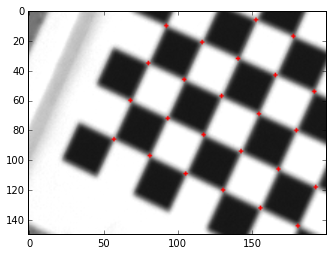

In [9]:
img = images[0].copy()
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
[cv2.circle(img, tuple(c),    1,(255,0,0), -1) for c in projected_points_pm]
# [cv2.circle(img, tuple(c),    1,(0,0,255), -1) for c in projected_points_ts]

plt.imshow(img[450:600,500:700], cmap='brg')